# LCLS cu_hxr from archived data

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from lcls_live.datamaps import get_datamaps
from lcls_live.archiver import lcls_archiver_restore

import os

In [4]:
BEAMPATH = 'cu_hxr'

## Datamaps, and all PVs needed

In [5]:
DM = get_datamaps(BEAMPATH)

DM.keys()

dict_keys(['bpms', 'correctors', 'subboosters', 'linac', 'K21_1', 'K21_2', 'K21_3', 'K21_4', 'K21_5', 'K21_6', 'K21_7', 'K21_8', 'K22_1', 'K22_2', 'K22_3', 'K22_4', 'K22_5', 'K22_6', 'K22_7', 'K22_8', 'K23_1', 'K23_2', 'K23_3', 'K23_4', 'K23_5', 'K23_6', 'K23_7', 'K23_8', 'K24_1', 'K24_2', 'K24_3', 'K24_4', 'K24_5', 'K24_6', 'K25_1', 'K25_2', 'K25_3', 'K25_4', 'K25_5', 'K25_6', 'K25_7', 'K25_8', 'K26_1', 'K26_2', 'K26_3', 'K26_4', 'K26_5', 'K26_6', 'K26_7', 'K26_8', 'K27_1', 'K27_2', 'K27_3', 'K27_4', 'K27_5', 'K27_6', 'K27_7', 'K27_8', 'K28_1', 'K28_2', 'K28_3', 'K28_4', 'K28_5', 'K28_6', 'K28_7', 'K28_8', 'K29_1', 'K29_2', 'K29_3', 'K29_4', 'K29_5', 'K29_6', 'K29_7', 'K29_8', 'K30_1', 'K30_2', 'K30_3', 'K30_4', 'K30_5', 'K30_6', 'K30_7', 'K30_8', 'quad', 'beginning_WS02', 'tao_energy_measurements'])

In [6]:
# datamaps to exclude
DENYLIST = ['beginning_WS02', 'quad', 'bpms', 'correctors']

In [7]:
# PVs needed
ALLPVS =  []
for name, dm in DM.items():
    if name in DENYLIST:
        continue
    ALLPVS.extend(dm.pvlist)
ALLPVS = list(set(ALLPVS))
len(ALLPVS)

553

## Archiver restore

In [8]:
ISOTIME = '2021-11-21T08:10:25.000000-07:00'

In [9]:
# Optional off-site setup

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 <some user>@<some SLAC machine>

OFFSITE=True

if OFFSITE:
    os.environ['http_proxy']='socks5h://localhost:8080'
    os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
    os.environ['ALL_PROXY']='socks5h://localhost:8080'

In [10]:
PVDATA = lcls_archiver_restore(ALLPVS, ISOTIME)

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2021-11-21T08:10:25.000000-07:00&includeProxies=true


## Form commands using PVDATA and datamaps

In [11]:
CMDS = []
for name, dm in DM.items():
    CMDS.extend(dm.as_tao(PVDATA))

CMDS[0:5]

['! Bad value for orbit.x[1][]: None',
 '! Bad value for orbit.x[2][]: None',
 '! Bad value for orbit.x[3][]: None',
 '! Bad value for orbit.x[4][]: None',
 '! Bad value for orbit.x[5][]: None']

# Start Tao

In [12]:
from pytao import Tao

In [13]:
tao = Tao(f'-init $LCLS_LATTICE/bmad/models/{BEAMPATH}/tao.init -slice BEGINNING:ENDUNDH -noplot')

In [14]:
# apply commands all at once
tao.cmds(CMDS);

In [15]:
# Explicitly save beam 
tao.cmd('set beam saved_at = MARKER::*')
#tao.cmd('set beam saved_at = BEGUNDH,ENDUNDH')

[]

In [16]:
# Turn on CSR
tao.cmd(f'call $LCLS_LATTICE/bmad/models/{BEAMPATH}/scripts/Activate_CSR.tao');

In [17]:
# Turn on the beam
tao.cmd('set beam_init n_particle = 10000')

[]

In [18]:
#toggle on and off
tao.cmd('set global track_type = beam', raises=False) 

['Beam at Element: 1679. Time: 1 min', 'Beam at Element: 1872. Time: 2 min']

In [19]:
tao.cmd('set global track_type = single') 

[]

## Get particles 

In [20]:
from pmd_beamphysics import ParticleGroup

In [21]:
P = ParticleGroup(data=tao.bunch_data('ENDUNDH'))
# Select out live particles
P = P[P.status==1]

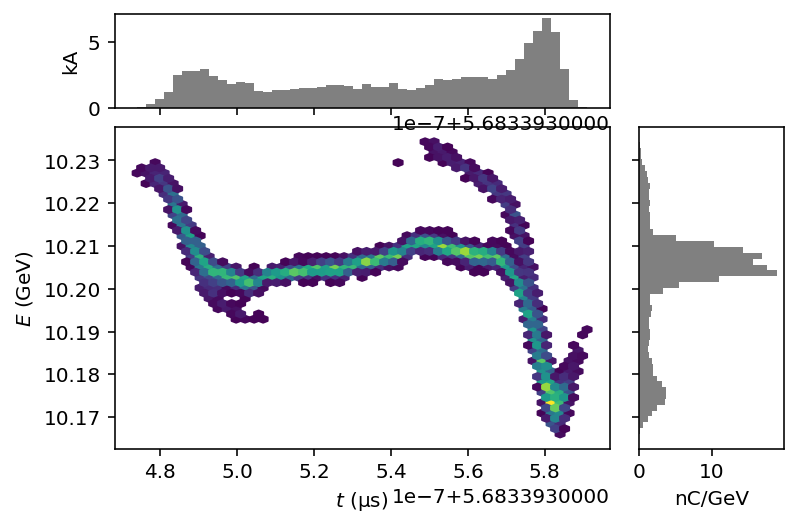

In [22]:
P.plot('t', 'energy')

In [23]:
# Make a function for this
def get_beam(ele):
    P = ParticleGroup(data=tao.bunch_data(ele))
    # Select out live particles
    P = P[P.status==1]    
    
    return P

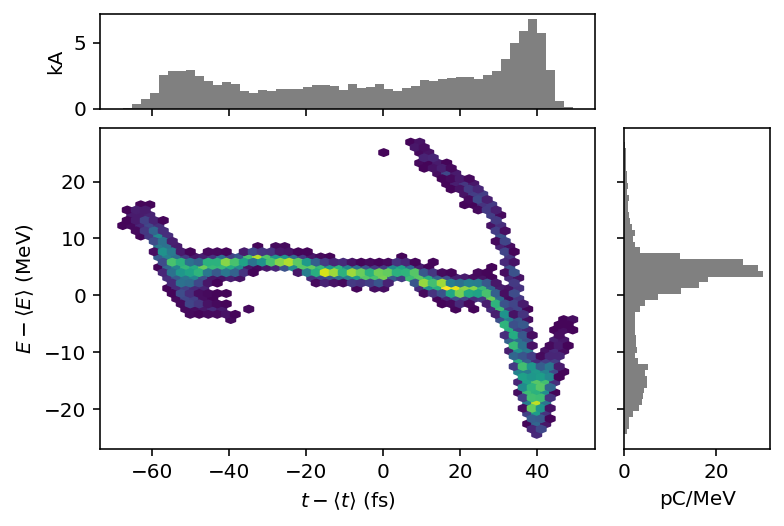

In [24]:
P1 = get_beam('BEGUNDH')
P1.plot('delta_t', 'delta_energy')

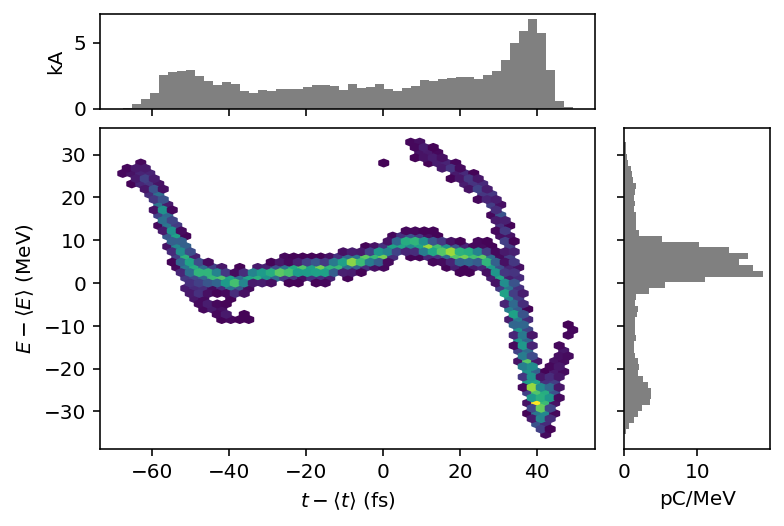

In [25]:
P2 = get_beam('ENDUNDH')
P2.plot('delta_t', 'delta_energy')

In [26]:
%%tao
sho beam 2823

-------------------------
Tao> sho beam 2823
Bunch parameters at: RFBHX45 (2823)
  Parameters for bunch:       1
  S-position:                   1.68055764E+03
  In branch:                  0
  Particles surviving:        10000
  Particles lost:             0
  Particles lost (%):         .000
  Charge live (C):              2.50000000E-10
  Centroid: -7.76130185E-05  2.11279989E-06  7.52340483E-08  1.73397823E-08 -5.71297016E-05 -2.82776806E-03
  RMS:       6.16340998E-05  2.68061431E-06  2.14073515E-05  1.98094351E-06  1.02469430E-05  8.82717218E-04

               norm_emitt            emit            beta           alpha
  a:         8.21719362E-07  4.11117286E-11  3.61999433E+01  1.79075358E+00
  b:         5.12404873E-07  2.56363073E-11  1.77459709E+01 -1.30780669E+00
  x:         9.33624400E-07  4.67104887E-11  3.41105299E+01  1.57513674E+00
  y:         5.13796157E-07  2.57059151E-11  1.78274499E+01 -1.31203839E+00
  z:         1.37544706E-04  6.88154725E-09  1.52581733E-02

Si

Text(0, 0.5, 'delta_energy (eV)')

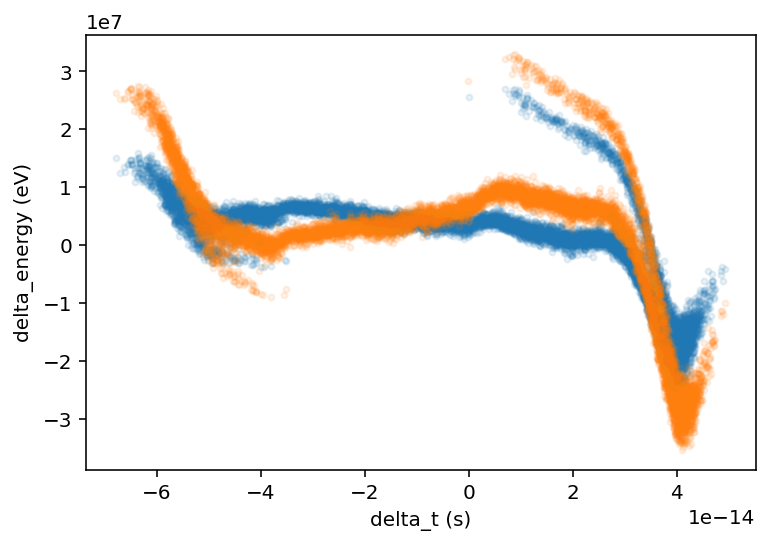

In [27]:
# Compare on the same plot
k1= 'delta_t'
k2 = 'delta_energy'
plt.scatter(P1[k1], P1[k2], marker='.', alpha=0.1)
plt.scatter(P2[k1], P2[k2], marker='.', alpha=0.1)
plt.xlabel(f'{k1} ({P1.units(k1).unitSymbol})')
plt.ylabel(f'{k2} ({P1.units(k2).unitSymbol})')

# Get giant table of bunch stats

In [28]:
import pandas as pd

In [29]:
# Get list of indices
IX = tao.lat_list('*', 'ele.ix_ele')

# Stop before the dump
S_STOP = tao.ele_head('ENDUNDH')['s']

stats = []
for ele in IX:
    d = tao.bunch_params(ele)
    # Skipl ones with no beam
    if d['charge_live'] == 0:
        continue
    
    if d['s'] > S_STOP:
        break
        
    stats.append(d)

df = pd.DataFrame(stats)#.set_index('ix_ele')


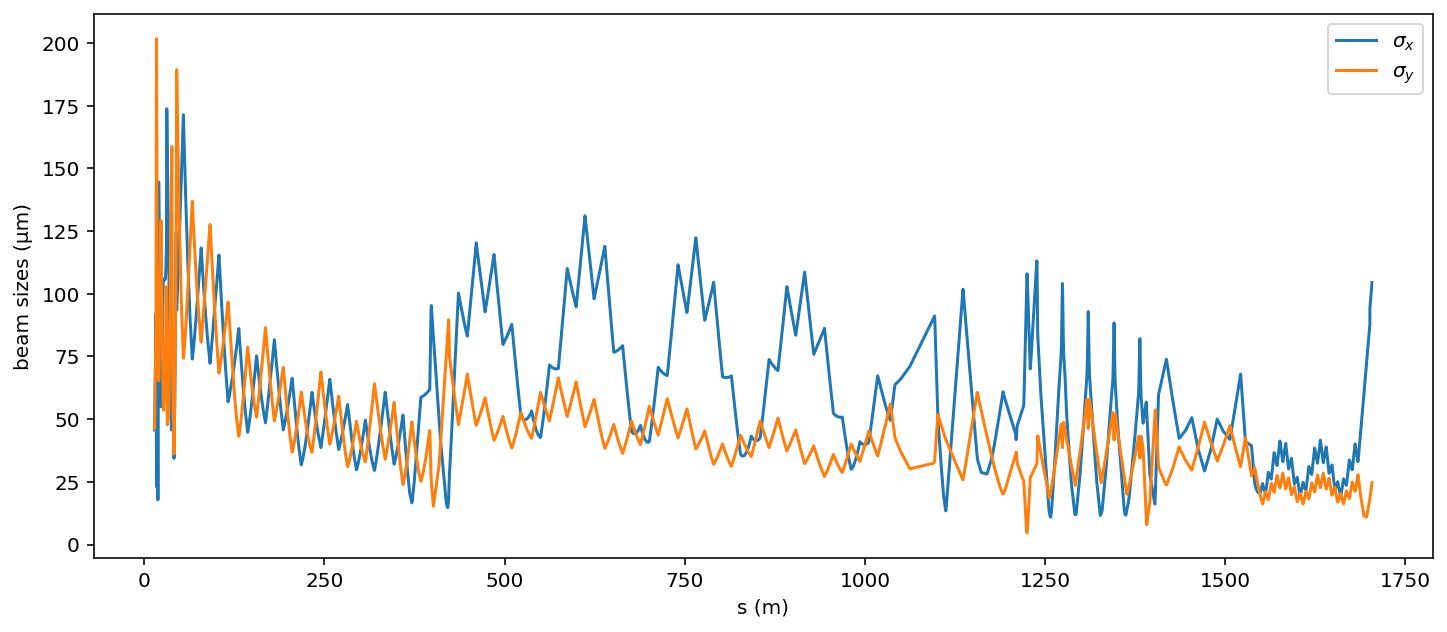

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['sigma_x']*1e6, label=r'$\sigma_x$')
plt.plot(df['s'], df['sigma_y']*1e6, label=r'$\sigma_y$')
plt.xlabel('s (m)')
plt.ylabel('beam sizes (µm)')
plt.legend();

In [31]:
# Get an array of where the beam is saved
s_saved = np.array(df[df['beam_saved']]['s'])

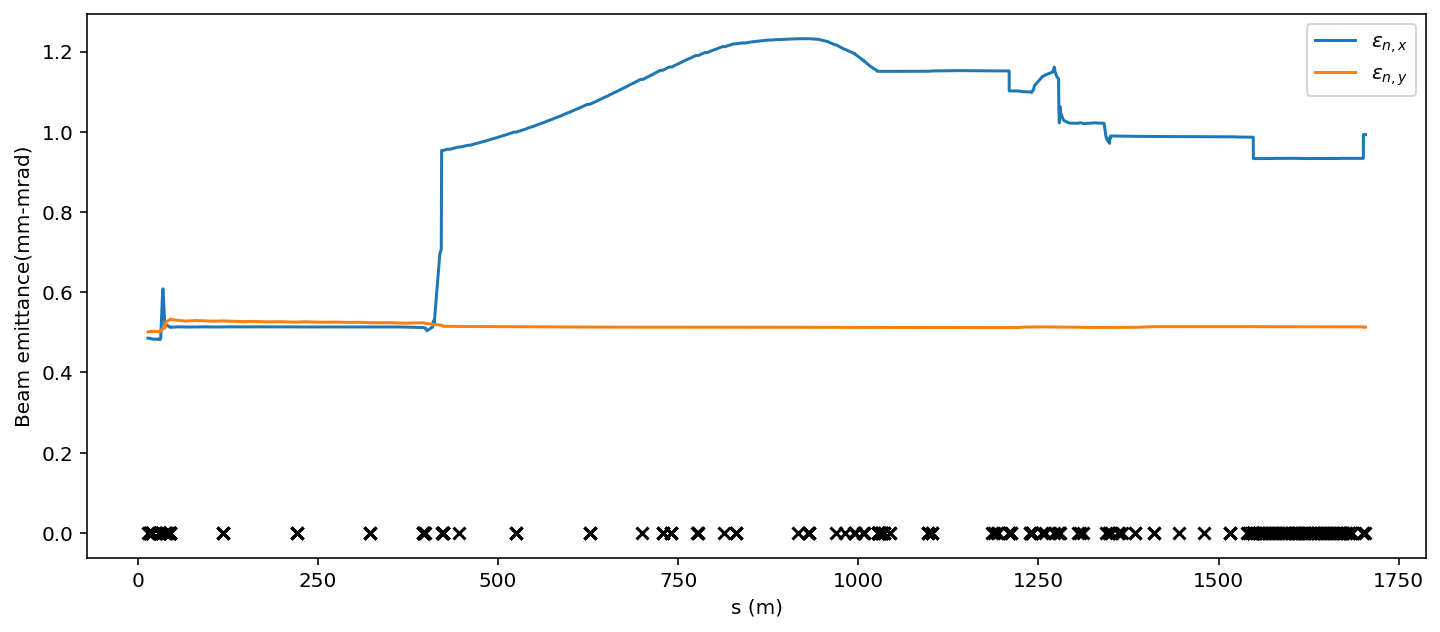

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['norm_emit_x']*1e6, label=r'$\epsilon_{n,x}$')
plt.plot(df['s'], df['norm_emit_y']*1e6, label=r'$\epsilon_{n,y}$')
plt.xlabel('s (m)')
plt.ylabel('Beam emittance(mm-mrad)')


# This is where the beam is saved
plt.scatter(s_saved, np.ones(len(s_saved))*0, color = 'black', marker = 'x')


plt.legend();